In [95]:
import sys
sys.path.insert(0, './python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import imp
imp.reload(model)
import random
from collections import defaultdict
import torch
import math

In [117]:
%matplotlib inline

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class myLayer(nn.Linear):
    def __init__(self, in_channels, out_channels, n, bias, exclusive):
        super(myLayer, self).__init__(in_channels * n, out_channels * n,
                                            bias)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n = n
        self.exclusive = exclusive

        self.register_buffer('mask', torch.ones([self.n] * 2))
        if self.exclusive:
            self.mask = 1. - torch.triu(self.mask)
        else:
            self.mask = torch.tril(self.mask)
        self.mask = torch.cat([self.mask] * in_channels, dim=1)
        self.mask = torch.cat([self.mask] * out_channels, dim=0)
        self.weight.data *= self.mask

        # Correction to Xavier initialization
        self.weight.data *= torch.sqrt(self.mask.numel() / self.mask.sum())

    def forward(self, x):
        return nn.functional.linear(x, self.mask * self.weight, self.bias)

default_dtype_torch = torch.float64

class bp_nn(nn.Module):
    def __init__(self, in_channels, out_channels, n, bias, exclusive):
        super(bp_nn, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n = n
        self.epsilon = 1e-10
        layers = []
        layer1 = myLayer(in_channels, out_channels, n, bias, exclusive)
        layers.append(layer1)
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

        
    def forward(self, x):
        return self.net(x)


    def sample(self, batch_size):
        sample = torch.zeros(
            [batch_size, 1, self.n])
        for i in range(self.n):
            x_hat = self.forward(sample)
            #print(x_hat)
            sample[:, :, i] = torch.bernoulli(
                    x_hat[:, :, i]) * 2 - 1
            
        return sample, x_hat

    def _log_prob(self, sample, x_hat):
        mask = (sample + 1) / 2
        log_prob = (torch.log(x_hat + self.epsilon) * mask +
                    torch.log(1 - x_hat + self.epsilon) * (1 - mask))
        log_prob = log_prob.view(log_prob.shape[0], -1).sum(dim=1)
        return log_prob

    def log_prob(self, sample):
        x_hat = self.forward(sample)
        log_prob = self._log_prob(sample, x_hat)
        return log_prob


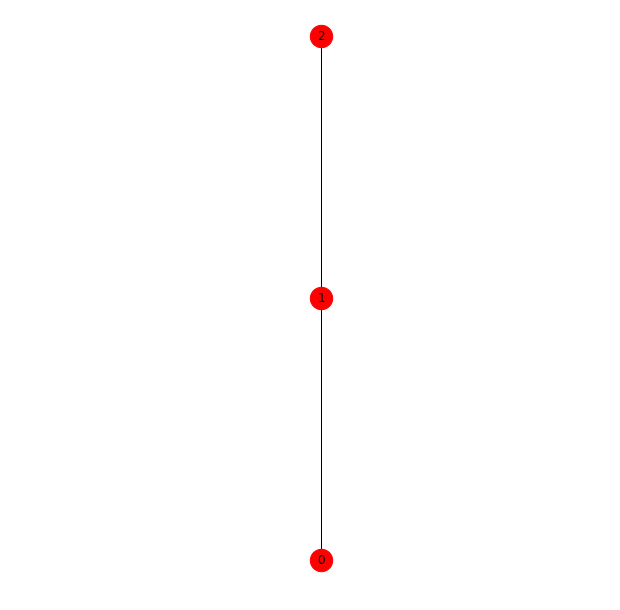

In [133]:
Degree = 2 # degree
Height = 2 # Height of the tree
N, J_interaction = graph_gen.tree_interaction(Degree,Height)
j = graph_gen.fixed_value(2)
J = graph_gen.set_J(J_interaction, j)
h = 1.
H = np.full((N,), h)
tree = model.model(N, H, J, J_interaction)

In [134]:
net = bp_nn(1,1,N,True, False)
sample, x_hat = net.sample(3)

In [135]:
lr = 1e-3
params = list(net.parameters())
params = list(filter(lambda p: p.requires_grad, params))
nparams = int(sum([np.prod(p.shape) for p in params]))
print('Total number of trainable parameters: {}'.format(nparams))
named_params = list(net.named_parameters())

optimizer = torch.optim.SGD(params, lr=lr)
optimizer.zero_grad()


Total number of trainable parameters: 12


In [136]:
net.sample(10)

(tensor([[[-1., -1., -1.]],
 
         [[ 1.,  1.,  1.]],
 
         [[ 1., -1.,  1.]],
 
         [[ 1., -1., -1.]],
 
         [[-1., -1.,  1.]],
 
         [[-1.,  1.,  1.]],
 
         [[ 1.,  1.,  1.]],
 
         [[-1.,  1., -1.]],
 
         [[-1., -1.,  1.]],
 
         [[-1., -1.,  1.]]], grad_fn=<CopySlices>),
 tensor([[[0.4145, 0.6806, 0.3871]],
 
         [[0.5239, 0.4057, 0.6122]],
 
         [[0.5239, 0.6780, 0.4002]],
 
         [[0.5239, 0.6780, 0.4002]],
 
         [[0.4145, 0.6806, 0.3871]],
 
         [[0.4145, 0.4085, 0.5991]],
 
         [[0.5239, 0.4057, 0.6122]],
 
         [[0.4145, 0.4085, 0.5991]],
 
         [[0.4145, 0.6806, 0.3871]],
 
         [[0.4145, 0.6806, 0.3871]]], grad_fn=<SigmoidBackward>))

In [139]:
max_step = 1000
beta_init = 1
beta_anneal = 0
step = 1
batch_size = 100
for step in range(0, max_step + 1):
        optimizer.zero_grad()
        with torch.no_grad():
            sample, x_hat = net.sample(batch_size)
        assert not sample.requires_grad
        assert not x_hat.requires_grad

        log_prob = net.log_prob(sample)
        beta = beta_init * (1 - beta_anneal**step)
        with torch.no_grad():
            energy = tree.energy(sample.double())
            loss = log_prob + beta * energy
        assert not energy.requires_grad
        assert not loss.requires_grad
        loss_reinforce = torch.mean((loss - loss.mean()) * log_prob)
        loss_reinforce.backward()

        optimizer.step()


RuntimeError: The size of tensor a (3) must match the size of tensor b (100) at non-singleton dimension 0

In [10]:
autoreg.weight

Parameter containing:
tensor([[-0.0794,  0.0000,  0.0000],
        [ 0.3742, -0.4221,  0.0000],
        [-0.5356,  0.6621,  0.6466]], requires_grad=True)

In [7]:
x = torch.Tensor([0,1,0])
autoreg.forward(x)

tensor([-0.3114, -1.0834,  0.1316], grad_fn=<AddBackward0>)

In [32]:
layers = []
layers.append(autoreg)
layers.append(nn.Sigmoid())
net = nn.Sequential(*layers)

In [34]:
net.forward(x)

tensor([0.3964, 0.4787, 0.5913], grad_fn=<SigmoidBackward>)

In [22]:
x = [0,0,1]
nn.functional.linear(

SyntaxError: unexpected EOF while parsing (<ipython-input-22-b6672e7dcdf1>, line 2)

In [17]:
ChannelLinear(1,1,10,True)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]

ChannelLinear(in_features=10, out_features=10, bias=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nn.Linear()